# Basic text classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents
* [Basic text classification with Naive Bayes](#BOW-model-and-Naive-Bayes)
	* [Rotten Tomatoes data set](#Rotten-Tomatoes-data-set)
		* [Explore](#Explore)
	* [The Vector space model and a search engine.](#The-Vector-space-model-and-a-search-engine.)
		* [In Code](#In-Code)
	* [Naive Bayes](#Naive-Bayes)
		* [Cross-Validation and hyper-parameter fitting](#Cross-Validation-and-hyper-parameter-fitting)
		* [Work with the best params](#Work-with-the-best-params)
	* [Interpretation](#Interpretation)
	* [Ideas to improve](#To-improve:)


## Rotten Tomatoes data set

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print "Number of reviews: %i" % n_reviews
print "Number of critics: %i" % n_critics
print "Number of movies:  %i" % n_movies

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


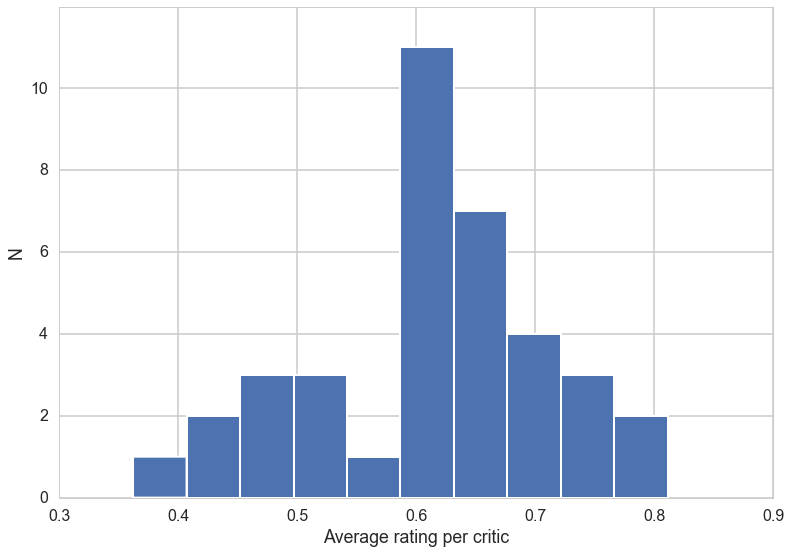

In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=2)
plt.xlabel("Average rating per critic")
plt.ylabel("N")
plt.yticks([0, 2, 4, 6, 8, 10]);

## The Vector space model and a search engine.

All the diagrams here are snipped from
See http://nlp.stanford.edu/IR-book/ which is a great resource on Text processing.

Also check out Python packages nltk, spacy, and pattern, and their associated resources.

Let us define the vector derived from document d by $\bar V(d)$. What does this mean? Each document is considered to be a vector made up from a vocabulary, where there is one axis for each term in the vocabulary.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Then the document

"hello world world"

would be indexed as

`[(5,1),(99,2)]`

along with a dictionary

``
5: Hello
99: World
``

so that you can see that our representation is one of a sparse array.

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays and columns "being" the features, ie the vocabulary. I put "being" in quites as the layout in memort is that of a matrix with many 0's, but, rather, we use the sparse representation we talked about above.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, jealous and jealousy after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all deoends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

This we can use this simple Vector Model as a Search engine.

### In Code

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print "Original text is\n", '\n'.join(text)

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print
print "Transformed text vector is \n", x

# `get_feature_names` tracks which word is associated with each column of the transformed x
print
print "Words for each feature:"
print vectorizer.get_feature_names()

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
[u'hop', u'off', u'on', u'pop']


In [6]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

$$P(c|d) \propto P(d|c) P(c) $$

$$P(d|c)  = \prod_k P(t_k | c) $$

the conditional independence assumption.

Then we see that for which c is $P(c|d)$ higher.

For floating point underflow we change the product into a sum by going into log space. So:

$$log(P(d|c))  = \sum_k log (P(t_k | c)) $$

But we must also handle non-existent terms, we cant have 0's for them:

$$P(t_k|c) = \frac{N_{kc}+\alpha}{N_c+\alpha N_{feat}}$$

**Your turn:** Implement a simple Naive Bayes classifier

* Use `scikit-learn`'s `MultinomialNB()`  classifier with default parameters.
* split the data set into a training and test set
* train the classifier over the training set and test on the test set
* print the accuracy scores for both the training and the test sets

What do you notice? Is this a good classifier? If not, why not?

Model accuracy using training dataset (containing 70% of samples): 0.9246
Model accuracy using test dataset (containing 30% of samples): 0.7683
Percent difference in accuracy between sets: -16.91%


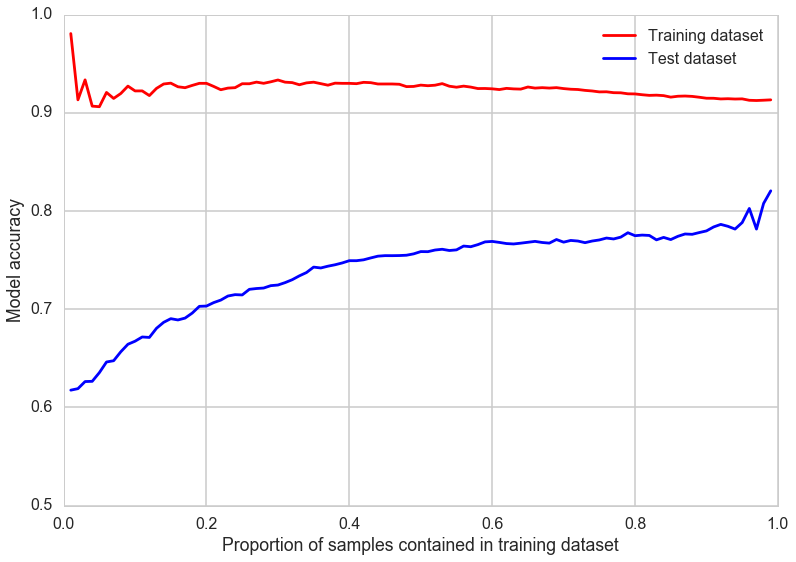

In [7]:
#your turn
import numpy as np
from sklearn import naive_bayes, cross_validation

# Setup our naive bayes model (with cross validation using training/test sets)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.3, random_state=1);
clf = naive_bayes.MultinomialNB();
clf.fit(X_train,y_train);

# Let's see how well the model predicts the test set
accuracy_TrainingSet = clf.score(X_train,y_train);
accuracy_TestSet     = clf.score(X_test,y_test);
print 'Model accuracy using training dataset (containing 70% of samples): {:5.4}'.format(accuracy_TrainingSet)
print 'Model accuracy using test dataset (containing 30% of samples): {:5.4}'.format(accuracy_TestSet)
print 'Percent difference in accuracy between sets: {:5.4}%'.format(100*(accuracy_TestSet-accuracy_TrainingSet)/accuracy_TrainingSet)

# Next let's systematically loop through different proportions allocated to the test/train sets
train_size_array = np.linspace(0.01,0.99,99);
accuracyScores  = np.zeros([len(train_size_array),2])
for [index,train_size] in enumerate(train_size_array):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,train_size=train_size, random_state=1);
    clf.fit(X_train,y_train);
    accuracyScores[index,0] = clf.score(X_train,y_train);
    accuracyScores[index,1] = clf.score(X_test,y_test);

# Plot the results    
fig=plt.figure();
axes=fig.add_axes();
plt.plot(train_size_array,accuracyScores[:,0],label='Training dataset',color='r')
plt.plot(train_size_array,accuracyScores[:,1],label='Test dataset',color='b')
plt.legend();
plt.ylim([0.5,1])
plt.ylabel('Model accuracy');
plt.xlabel('Proportion of samples contained in training dataset')

Based on accuracy, our simple Naive Bayes classifier does not classify too well. While the classifier performs well on the training dataset (>0.9), the classifier fails to generalize on training sets where performance ranges between 0.6-0.8 depending on the training set size. 

Because there is consistent improvement in the classifier by increasing the training set size, this likely means that features (i.e. words) are being used differently across reviews that makes it hard for the model to accurately classify whether a given review is fresh/rotten merely by the presence of words alone. For example, one critic might give a rotten rating with "This movie is not this director's best film, but has some moments worth watching." But this review could be changed to make it a Fresh Rating too: "Some moments are not worth watching, but this movie is this director's best film." The underlying problem is that stronger content words ("not", "worth", and "best") can sometimes be shared equally by two very different ratings (either fresh or rotten). Thus, sometimes more context between words is needed than merely just their presence in a review, especially if the review is borderline Fresh/rotten. That's because we should expect that both positive and negative words are likely to be used together in mixed/borderline reviews. 

### Cross-Validation and hyper-parameter fitting

We use `KFold` instead of `GridSearchCV` here as we will want to also set parameters in the CountVectorizer.

In [8]:
from sklearn.cross_validation import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

Since Naive Bayes classifiers are often used in asymmetric situations, it might help to actually maximize probability on the validation folds rather than just accuracy.

Notice something else about using a custom score function. It allows us to do a lot of the choices with the Decision risk we care about (-profit for example) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as risks or scores.

In [9]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

**Your turn:** What is using this function as the score mean? What are we trying to optimize for?

The log-likelihood function is being used here to maximize true positives and true negatives. As each probability value is expressed as a logarithmic probability (i.e. a negative number), a more positive sum returned by this function indicates the confidence in true positives and true negatives by the classifier. This is because prob[rotten,0] will return the true negatives, while prob[fresh,1] will return the true positives.

We'll cross-validate over the regularization parameter $\alpha$ and the `min_df` of the `CountVectorizer`.

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

Lets set up the train and test masks first:

In [10]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(critics.shape[0]), train_size=0.7, random_state=1)
mask=np.ones(critics.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

**Your turn:** 
    
Using the skeleton code below, find the best values of the parameters `alpha` and `min_df`. 
Use the `cv_score` function above with the `log_likelihood` function for scoring.

In [11]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        
        #your turn
        clf = naive_bayes.MultinomialNB(alpha=alpha);
        clf.fit(Xtrainthis,ytrainthis)
        score = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood); 
        print "alpha = {:3.1f}, min_df = {:5.5f}, score = {:5.2f}, accuracy = {:3.2f}".format(alpha,min_df,score,clf.score(Xtrainthis, ytrainthis))
        if score>maxscore:
            maxscore    = score;
            best_alpha  = alpha;
            best_min_df = min_df;

alpha = 0.0, min_df = 0.00001, score =   nan, accuracy = 0.88
alpha = 0.0, min_df = 0.00010, score =   nan, accuracy = 0.88
alpha = 0.0, min_df = 0.00100, score =   nan, accuracy = 0.79
alpha = 0.0, min_df = 0.01000, score = -1381.94, accuracy = 0.66
alpha = 0.0, min_df = 0.10000, score = -1446.22, accuracy = 0.61
alpha = 0.1, min_df = 0.00001, score = -1906.45, accuracy = 0.91
alpha = 0.1, min_df = 0.00010, score = -1907.37, accuracy = 0.90
alpha = 0.1, min_df = 0.00100, score = -1364.36, accuracy = 0.79
alpha = 0.1, min_df = 0.01000, score = -1381.84, accuracy = 0.66
alpha = 0.1, min_df = 0.10000, score = -1446.22, accuracy = 0.61
alpha = 1.0, min_df = 0.00001, score = -1321.53, accuracy = 0.89
alpha = 1.0, min_df = 0.00010, score = -1283.43, accuracy = 0.88
alpha = 1.0, min_df = 0.00100, score = -1270.02, accuracy = 0.79
alpha = 1.0, min_df = 0.01000, score = -1380.98, accuracy = 0.66
alpha = 1.0, min_df = 0.10000, score = -1446.22, accuracy = 0.61
alpha = 5.0, min_df = 0.00001, sco

In [12]:
print "alpha: %f" % best_alpha
print "min_df: %f" % best_min_df

alpha: 5.000000
min_df: 0.001000


### Work with the best params

**Your turn: **  Using the best values of  `alpha` and `min_df` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?

Accuracy on training data: 0.79
Accuracy on test data:     0.74


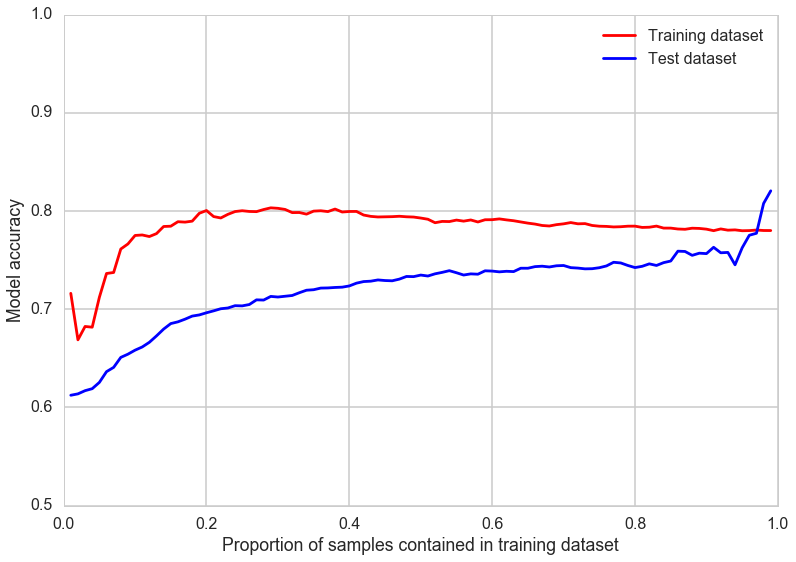

In [13]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]
clf = naive_bayes.MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy     = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

# Next let's systematically loop through different proportions allocated to the test/train sets
train_size_array = np.linspace(0.01,0.99,99);
accuracyScores  = np.zeros([len(train_size_array),2])
for [index,train_size] in enumerate(train_size_array):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,train_size=train_size, random_state=1);
    clf = naive_bayes.MultinomialNB(alpha=best_alpha).fit(X_train, y_train)
    accuracyScores[index,0] = clf.score(X_train,y_train);
    accuracyScores[index,1] = clf.score(X_test,y_test);

# Plot the results    
fig=plt.figure();
axes=fig.add_axes();
plt.plot(train_size_array,accuracyScores[:,0],label='Training dataset',color='r')
plt.plot(train_size_array,accuracyScores[:,1],label='Test dataset'    ,color='b')
plt.legend();
plt.ylim([0.5,1])
plt.ylabel('Model accuracy');
plt.xlabel('Proportion of samples contained in training dataset')

In [14]:
from sklearn.metrics import confusion_matrix
confusionMatrix = confusion_matrix(ytest, clf.predict(xtest));
print "Performance of model on Test Set:"
print "True Rotten: {:3.0f} ({:0.3f}%)".format(confusionMatrix[0,0],(100.*confusionMatrix[0,0])/len(ytest))
print "False Rotten: {:3.0f} ({:0.3f}%)".format(confusionMatrix[0,1],(100.*confusionMatrix[0,1])/len(ytest))
print "True Fresh: {:3.0f} ({:0.3f}%)".format(confusionMatrix[1,1],(100.*confusionMatrix[1,1])/len(ytest))
print "False Fresh: {:3.0f} ({:0.3f}%)".format(confusionMatrix[1,0],(100.*confusionMatrix[1,0])/len(ytest))
print "Model {:0.3f}% correct on Fresh ratings".format((100.*confusionMatrix[1,1])/np.sum(confusionMatrix[:,1],axis=0))
print "Model {:0.3f}% correct on Rotten ratings".format((100.*confusionMatrix[0,0])/np.sum(confusionMatrix[:,0],axis=0))

Performance of model on Test Set:
True Rotten: 1219 (26.108%)
False Rotten: 581 (12.444%)
True Fresh: 2465 (52.795%)
False Fresh: 404 (8.653%)
Model 80.926% correct on Fresh ratings
Model 75.108% correct on Rotten ratings


So the classification accuracy of the model worsens a bit on the test set by optimizing the model's parameters, in which the model classifies correctly about 73% of the time (instead of 77%). This is not all that surprising because our model was optimized by maximizing the probability of the validation folds (i.e. a larger score for true positives or true negatives) than simple classification accuracy. One reason for the drop in classification accuracy is that it's possible that by eliminating rare features (i.e. words) in the model, there is a slight loss in performance. This is because the model could be over-reliant on rare features to make a classifiction. 

## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [15]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print "Good words\t     P(fresh | word)"
for w, p in zip(good_words, good_prob):
    print "%20s" % w, "%0.2f" % (1 - np.exp(p))
    
print "Bad words\t     P(fresh | word)"
for w, p in zip(bad_words, bad_prob):
    print "%20s" % w, "%0.2f" % (1 - np.exp(p))

Good words	     P(fresh | word)
             delight 0.92
            touching 0.90
         masterpiece 0.90
          remarkable 0.89
              superb 0.88
               witty 0.87
        entertaining 0.87
                rare 0.87
            captures 0.87
         intelligent 0.87
Bad words	     P(fresh | word)
            tiresome 0.20
             muddled 0.20
      disappointment 0.18
                dull 0.17
             unfunny 0.16
               bland 0.15
          uninspired 0.14
           pointless 0.14
       unfortunately 0.13
                lame 0.12


**Your turn:** Why does this method work? What does the probability for each row in the identity matrix represent?

Because this method is creating a "pseudo"-test set, in which only single features (i.e. words) are being tested at a single time. Previously we were testing the classifier on full-sentences, which are an amalgamation of different features. 

The probability for each row in the identity matrix represents the likelihood (in logarithmic form) of a fresh rating given the feature (i.e. fresh | word).

### Mis-predictions

We can see mis-predictions as well.

In [16]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print "Mis-predicted Rotten quotes"
print '---------------------------'
for row in bad_rotten:
    print critics[y == 0].quote.irow(row)
    print

print "Mis-predicted Fresh quotes"
print '--------------------------'
for row in bad_fresh:
    print critics[y == 1].quote.irow(row)
    print

Mis-predicted Rotten quotes
---------------------------
It survives today only as an unusually pure example of a typical 50s art-film strategy: the attempt to make the most modern and most popular of art forms acceptable to the intelligentsia by forcing it into an arcane, antique mold.

Benefits from a lively lead performance by the miscast Denzel Washington but doesn't come within light years of the book, one of the greatest American autobiographies.

It is sometimes funny in a puzzling kind of way, it is generally overwrought in an irritating kind of way, and once in a while it is inappropriately touching.

This pacifist spirit of brotherhood echoes the heroics in Princess Mononoke and other anime titles, but the artistic gap between the Miyazaki masterpiece and this project is huge.

The Waterboy is arguably Sandler's most enjoyable motion picture to date, but it's still far from a masterpiece.

Mis-predicted Fresh quotes
--------------------------
The gangland plot is flimsy (bad g

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: irow(i) is deprecated. Please use .iloc[i] or .iat[i]
C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:18: FutureWarning: irow(i) is deprecated. Please use .iloc[i] or .iat[i]


### Predicting the freshness for a new review

**Your turn:**

* Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
* Is the result what you'd expect? Why (not)?

In [17]:
#your turn
newReview = ['This movie is not remarkable, touching, or superb in any way'];
"Movie Review is expected to be fresh, because state {} is predicted ".format(clf.predict(vectorizer.transform(newReview))[0])

'Movie Review is expected to be fresh, because state 1 is predicted '

Yes, this is predicted because the words "remarkable," "touching," and "superb" are words generally used in the context of a fresh review, even though this is a rotten review. This is the underlying problem with merely creating a classifier using words alone that are missing context.

## Fun things to try and improve this model:

There are many things worth trying. Some examples:

- You could try to build a NB model where the features are word pairs instead of words. This would be smart enough to realize that "not good" and "so good" mean very different things. This technique doesn't scale very well, since these features are much more sparse (and hence harder to detect repeatable patterns within).
- You could try a model besides NB, that would allow for interactions between words -- for example, a Random Forest classifier.
- You could consider adding supplemental features -- information about genre, director, cast, etc.
- You could build a visualization that prints word reviews, and visually encodes each word with size or color to indicate how that word contributes to P(Fresh). For example, really bad words could show up as big and red, good words as big and green, common words as small and grey, etc.

### Better features

We could use TF-IDF instead. What is this? It stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weigh this term frequency by the inverse of its popularity in all document. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. By weighing its counts by 1 divides by its overall frequency, we down-weight it. We can then use this tfidf weighted features as inputs to any classifier.

In [18]:
#http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
#http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

**Your turn (extra credit):** Try a few of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result.

Accuracy on training data: 0.74
Accuracy on test data:     0.71


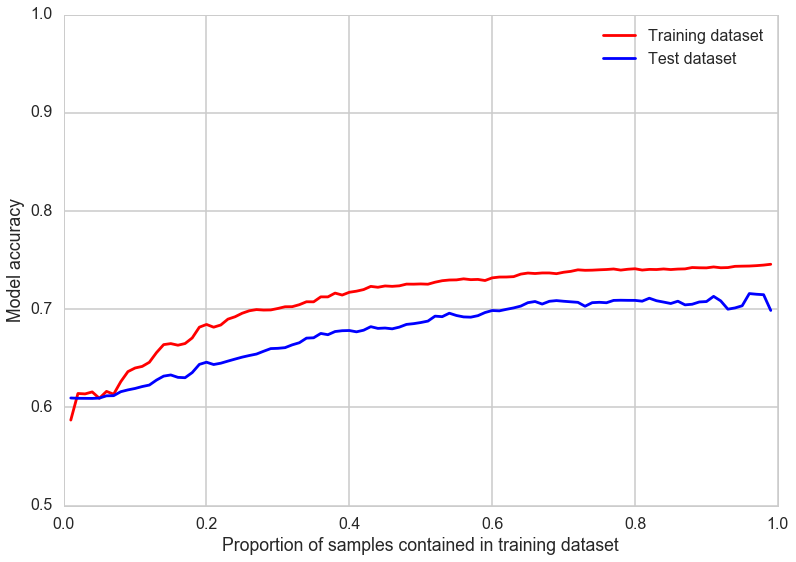

In [19]:
tfidfvectorizer = TfidfVectorizer(min_df=best_min_df, stop_words='english')
X, y = make_xy(critics, tfidfvectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]
clf = naive_bayes.MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy     = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

# Next let's systematically loop through different proportions allocated to the test/train sets
train_size_array = np.linspace(0.01,0.99,99);
accuracyScores  = np.zeros([len(train_size_array),2])
for [index,train_size] in enumerate(train_size_array):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,train_size=train_size, random_state=1);
    clf = naive_bayes.MultinomialNB(alpha=best_alpha).fit(X_train, y_train)
    accuracyScores[index,0] = clf.score(X_train,y_train);
    accuracyScores[index,1] = clf.score(X_test,y_test);

# Plot the results    
fig=plt.figure();
axes=fig.add_axes();
plt.plot(train_size_array,accuracyScores[:,0],label='Training dataset',color='r')
plt.plot(train_size_array,accuracyScores[:,1],label='Test dataset'    ,color='b')
plt.legend();
plt.ylim([0.5,1])
plt.ylabel('Model accuracy');
plt.xlabel('Proportion of samples contained in training dataset')